In [1]:
%matplotlib inline

import os
import itertools

import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

from hep2_classification.segmentation import SegmentationResult
from hep2_classification.presentation import display_grid, ImagePlotter

In [20]:
%%time

data_dir = '../data/segmented/'

def core_name(file):
    return file.split('/')[-1].split('-')[0]

files = [os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'NEG' not in f]

cells_dict = {}

for f in files:
    results = SegmentationResult.load(f)
    name = core_name(f)
    cells_list = cells_dict.get(name, [])
    cells_dict[name] = cells_list + list(results.cells)

for name, cells in cells_dict.items():
    print(name, len(cells))

ZIA 1532
NUC 659
HOM 862
DOT 556
ACA 1664
FIB 331
AMA 396
CPU times: user 3.15 s, sys: 75.6 ms, total: 3.22 s
Wall time: 3.25 s


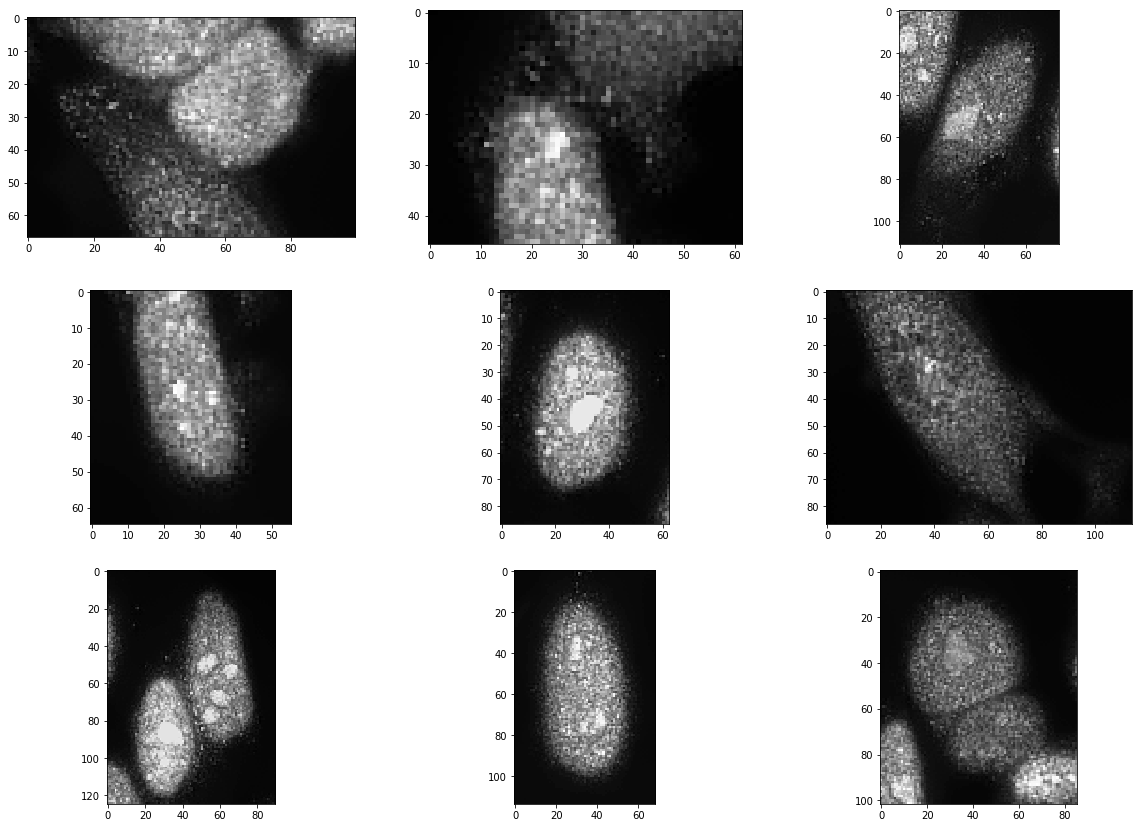

In [4]:
display_grid(cells[:9], ImagePlotter())

## normalizing images

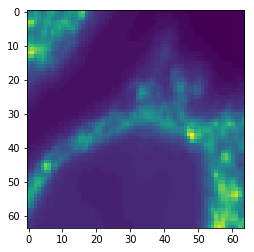

In [23]:
def prepare(img, target_size):
    
    return cv2.resize(img, target_size) / 255

plt.imshow(prepare(cells[0], target_size=(64, 64)))

CPU times: user 634 ms, sys: 112 ms, total: 746 ms
Wall time: 744 ms


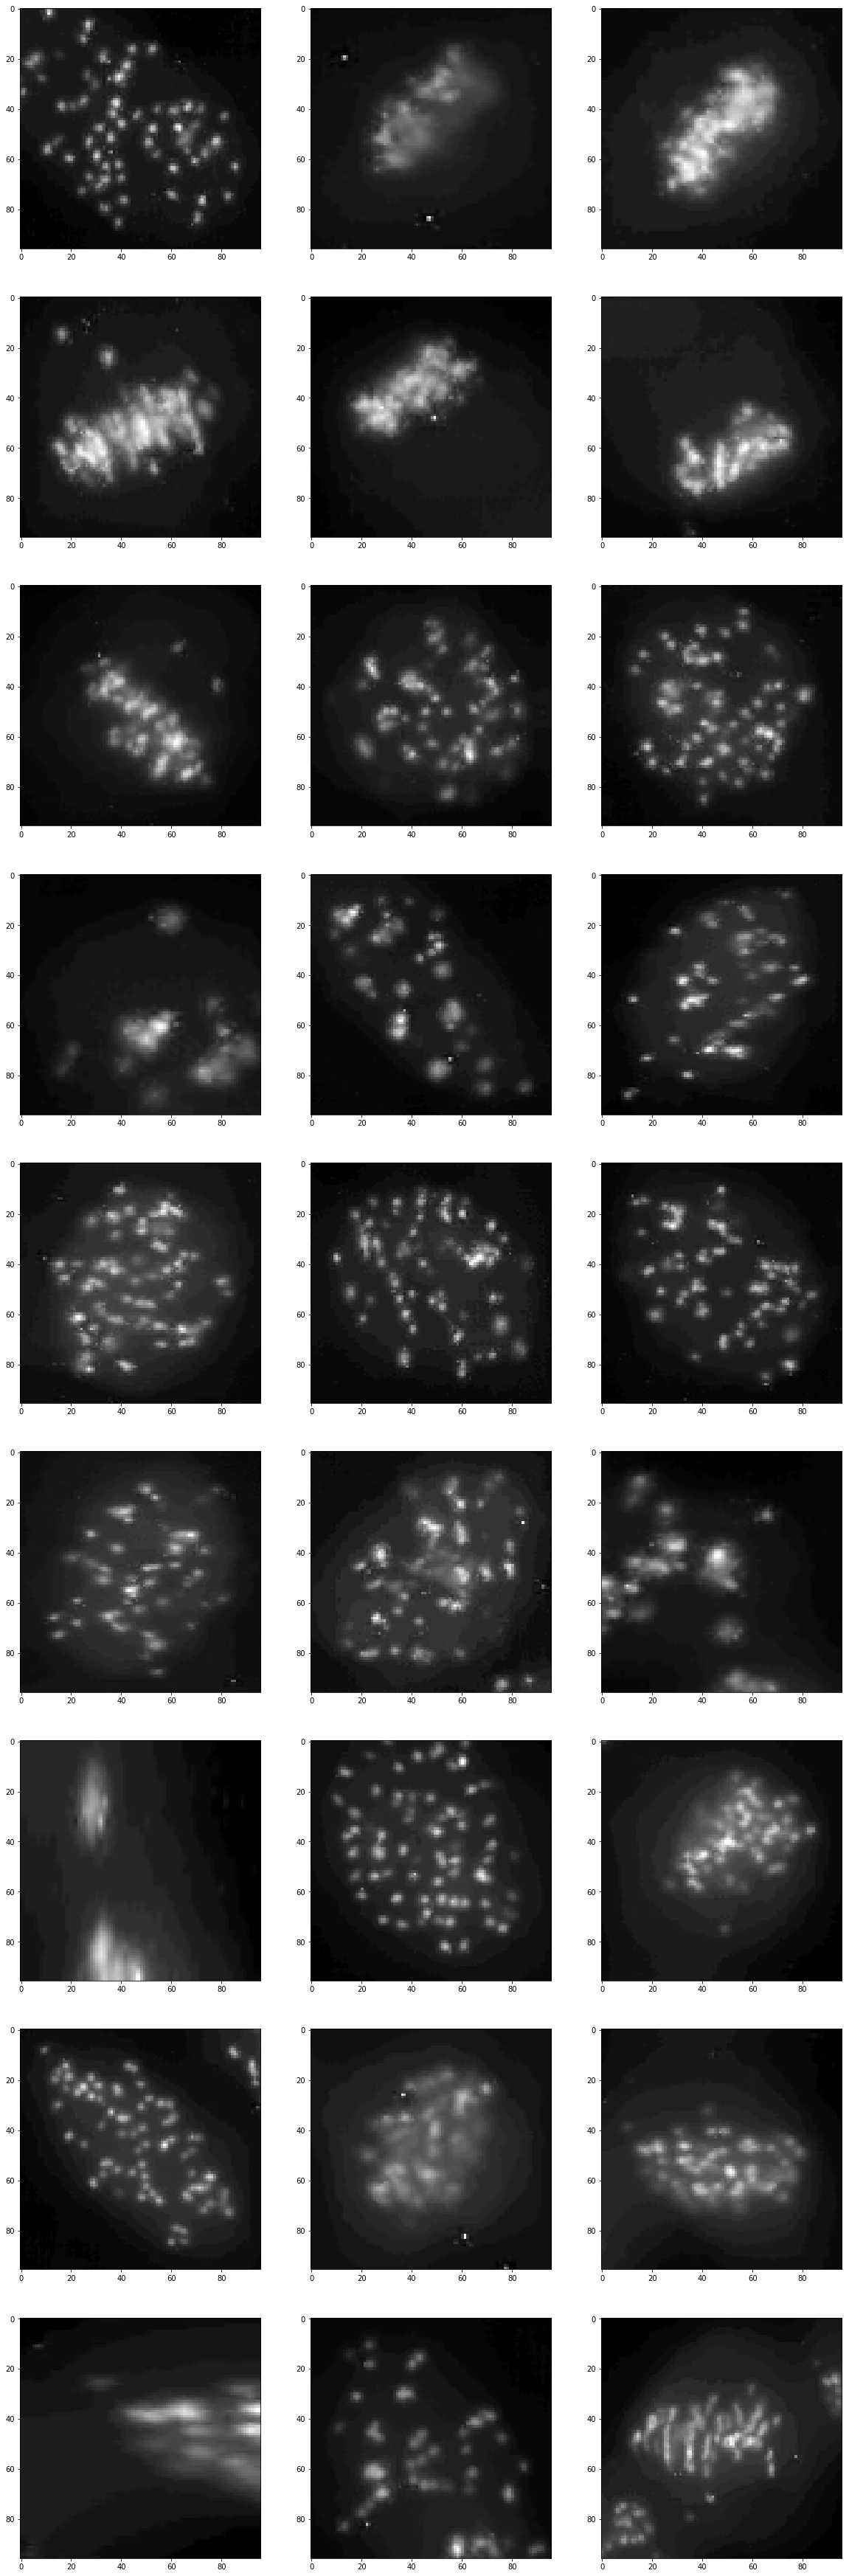

In [65]:
%%time

size = (96, 96)

cells_scaled = {
    name: [prepare(i, target_size=size) for i in cells]
    for name, cells in cells_dict.items()
}
display_grid(cells_scaled['ACA'][:27], ImagePlotter())

## preparing dataset

In [66]:
samples_per_class = 650
classes = ['ACA', 'ZIA', 'HOM', 'NUC']

X = np.concatenate([cells_scaled[c][:samples_per_class] for c in classes])
X = np.expand_dims(X, axis=3)
print(X.shape)

y = np.concatenate([[i] * samples_per_class for i in range(len(classes))])
print(y.shape)

dataset = X, y

(2600, 96, 96, 1)
(2600,)


## building model

In [67]:
model_input = keras.Input(shape=(size[0], size[1], 1), name='img')
x = layers.Conv2D(16, 3, activation='relu')(model_input)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.Conv2D(16, 3, activation='relu')(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Flatten()(x)
x = layers.Dense(200)(x)
x = layers.Dense(800)(x)
model_output = layers.Dense(len(classes), activation='softmax')(x)

model = keras.Model(model_input, model_output, name='cells-classifier')
model.summary()

Model: "cells-classifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 96, 96, 1)]       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 94, 94, 16)        160       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 92, 92, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 26, 26, 16)        4624      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 16)     

In [72]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [70]:
X, y = dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train = np.concatenate([X_train, np.flip(X_train, axis=2)])
y_train = np.concatenate([y_train, y_train])

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3640, 96, 96, 1), (3640,), (780, 96, 96, 1), (780,))

In [73]:
model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=512,
    shuffle=True,
    validation_data=(X_test, y_test)
)

Train on 3640 samples, validate on 780 samples
Epoch 1/30
3640/3640 [==============================] - 7s 2ms/sample - loss: 1.3009 - val_loss: 1.0738
Epoch 2/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 1.0305 - val_loss: 0.9941
Epoch 3/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.9063 - val_loss: 0.8880
Epoch 4/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.8208 - val_loss: 0.8182
Epoch 5/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.7693 - val_loss: 0.7943
Epoch 6/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.7467 - val_loss: 0.7974
Epoch 7/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.6925 - val_loss: 0.7745
Epoch 8/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.6666 - val_loss: 0.7112
Epoch 9/30
3640/3640 [==============================] - 6s 2ms/sample - loss: 0.6025 - val_loss: 0.6935
Epoch 10/30
3640/

In [74]:
test_preds = model.predict(X_test)
test_preds = np.argmax(test_preds, axis=1)
print('predicted:\t', test_preds[0:18])
print('true:\t\t', y_test[0:18])

predicted:	 [1 3 2 2 1 1 2 2 2 1 2 0 3 2 0 2 0 3]
true:		 [1 3 2 1 1 1 2 2 2 1 1 3 3 2 0 2 0 3]


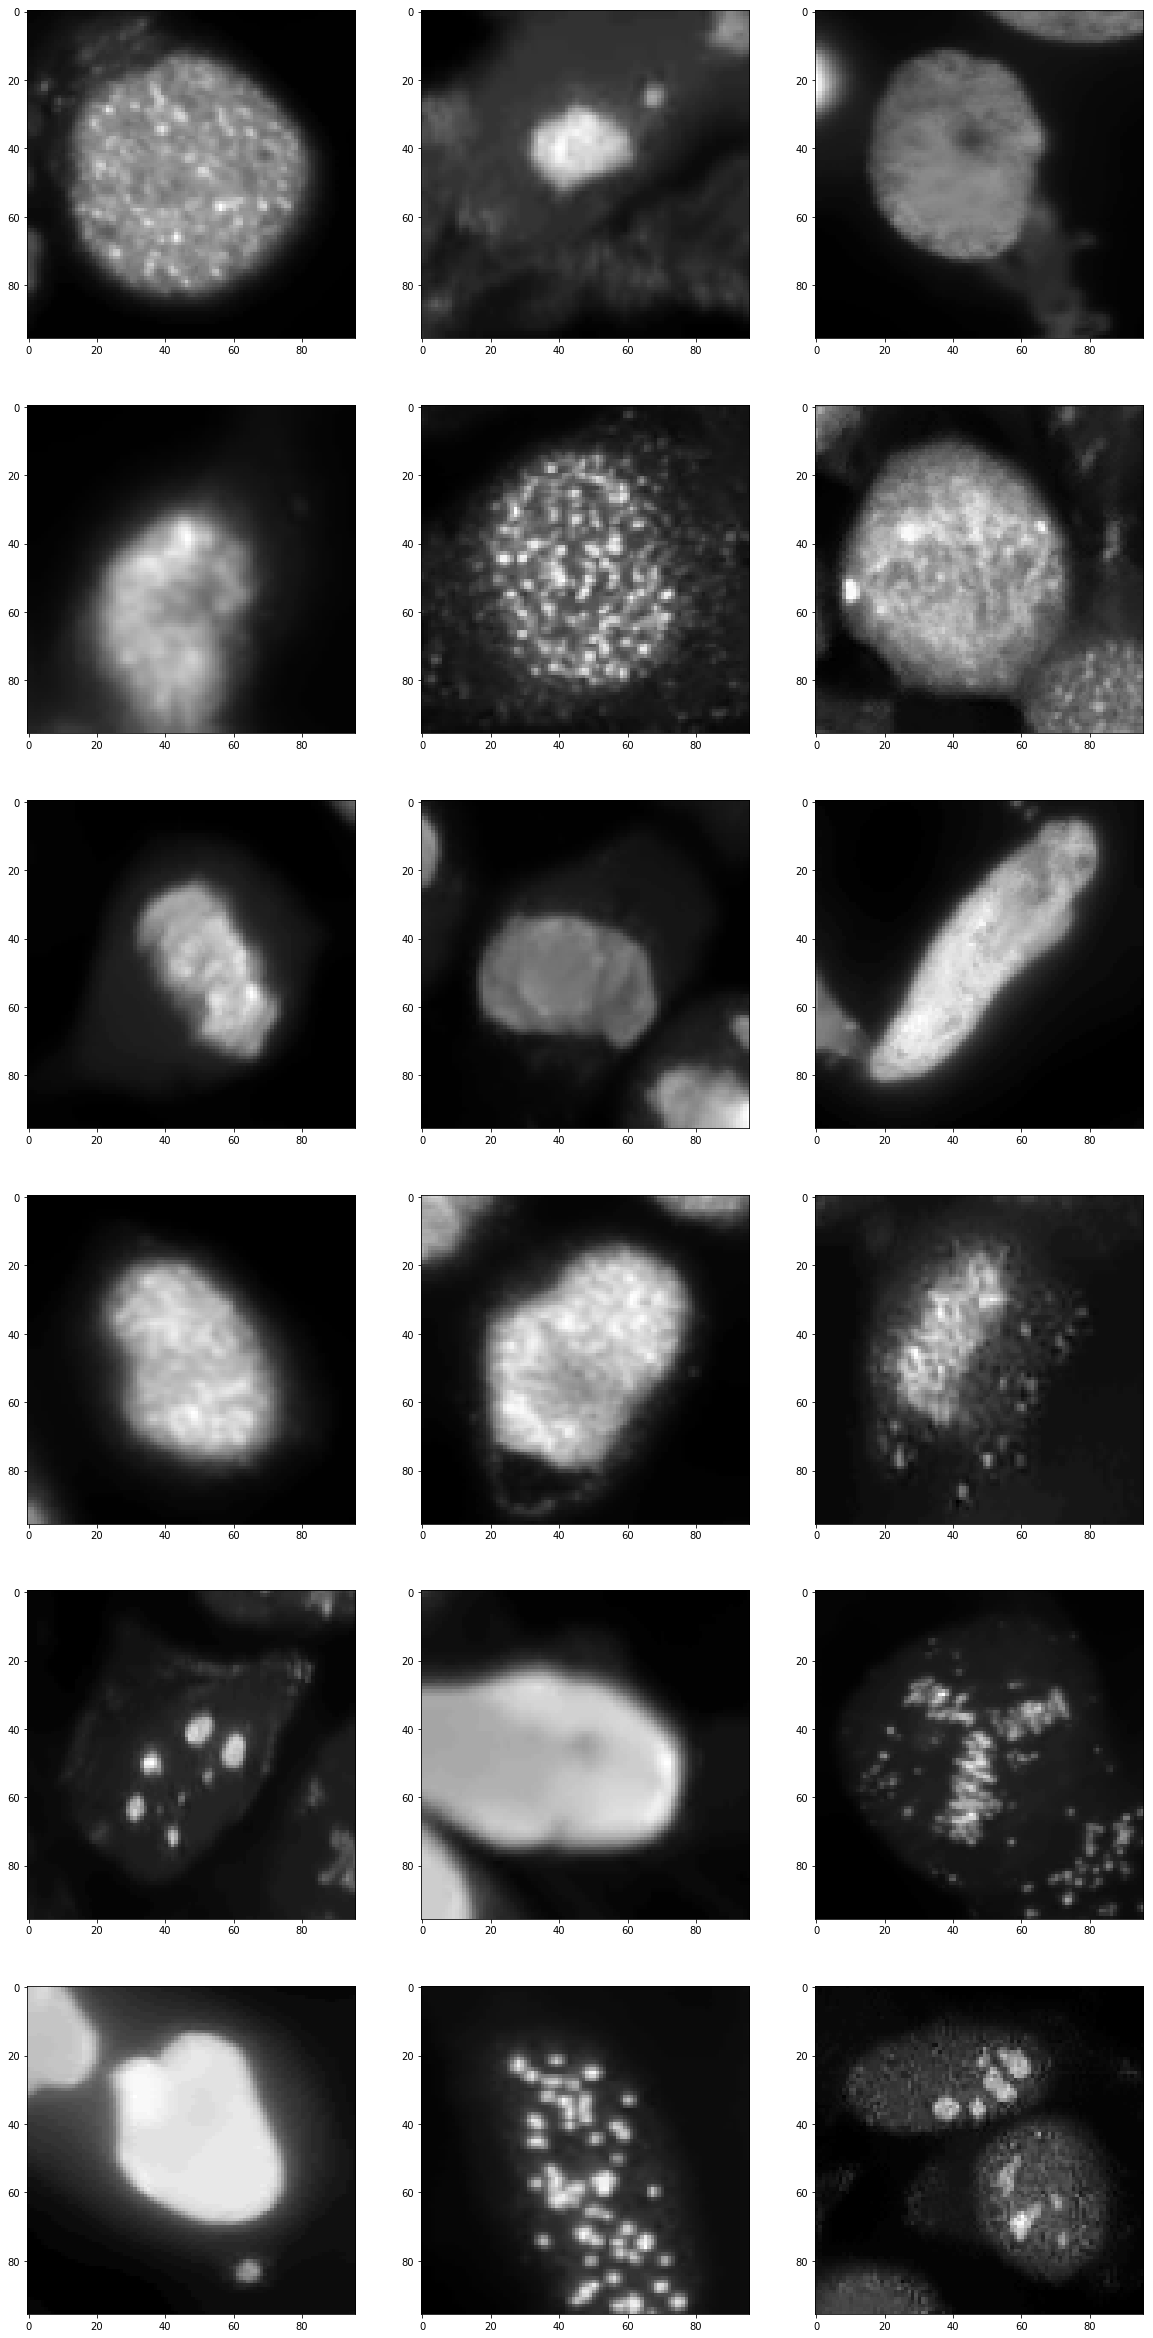

In [75]:
display_grid(np.squeeze(X_test[0:18], axis=3), ImagePlotter())

In [76]:
validation = (test_preds == y_test)

In [77]:
np.mean(validation)

0.8

In [78]:
incorrect_X = X_test[validation == False]
incorrect_X = incorrect_X.reshape(incorrect_X.shape[:3])
incorrect_true_y = y_test[validation == False]
incorrect_pred_y = test_preds[validation == False]
true_titles = [classes[i] for i in incorrect_true_y]
pred_titles = [classes[i] for i in incorrect_pred_y]
titles = [f'true: {t}, pred: {p}' for t, p in zip(true_titles, pred_titles)]

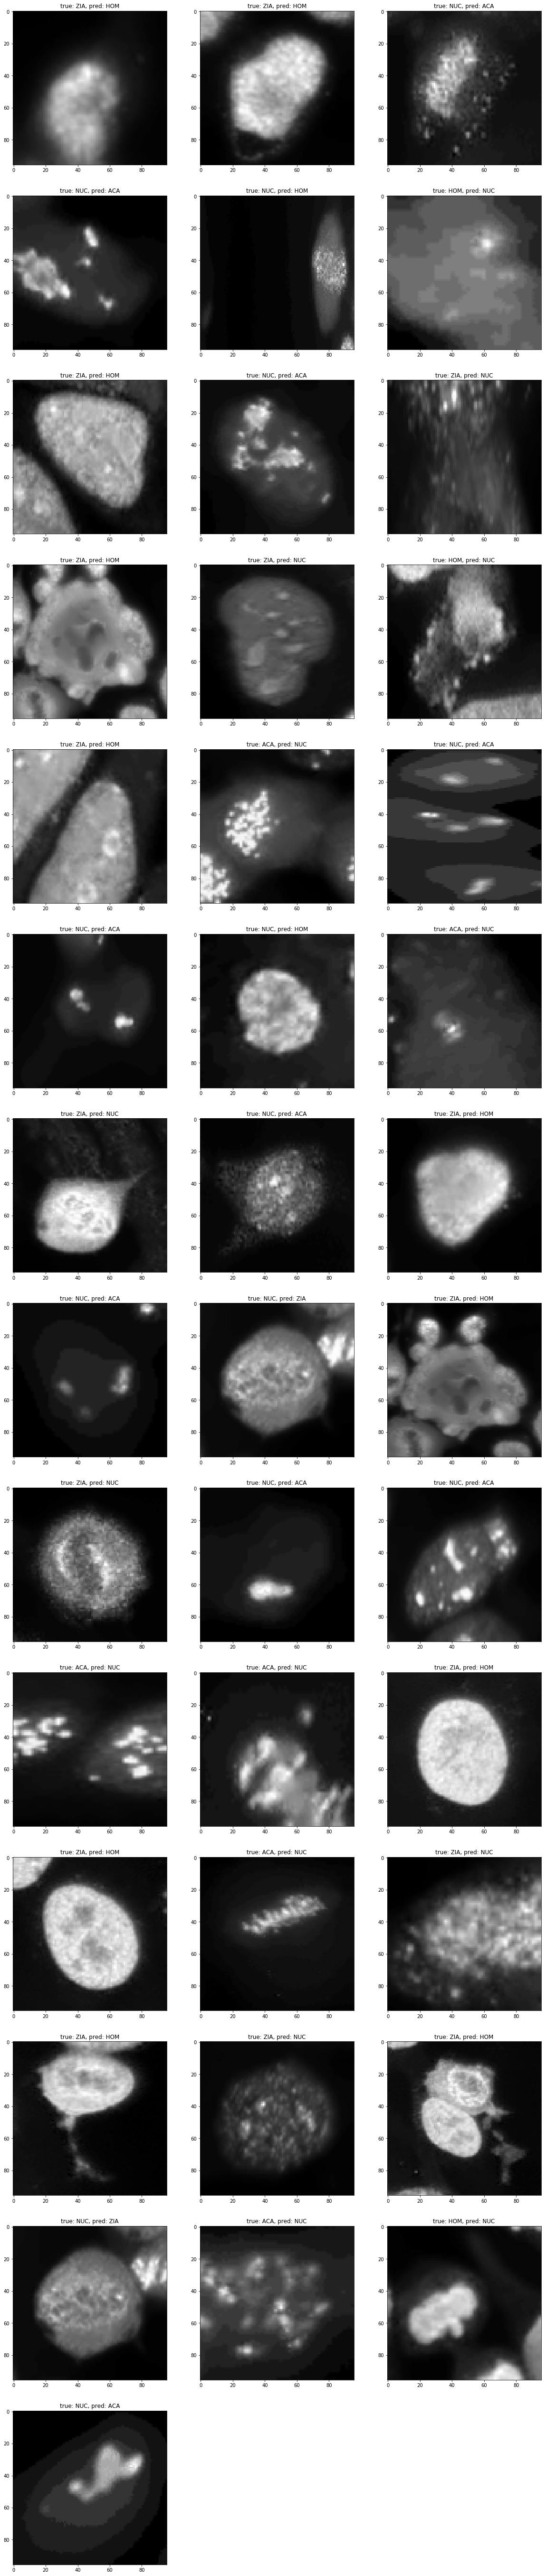

In [79]:
display_grid(incorrect_X[:40], ImagePlotter(), titles=titles[:40])